# APS360 Piano Transcription Project

## 1. Setup and Imports
Every Import needed for the project is below:

In [2]:
# We setup the environment
try:
    import google.colab
    IN_COLAB = True
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install librosa soundfile pretty_midi -q
    print("Running in Google Colab")
except ImportError:
    IN_COLAB = False
    print("Running locally")

# Standard imports
import os, json, warnings, zipfile, urllib.request, random
from pathlib import Path
from collections import defaultdict
from typing import Tuple, Dict, List

# Core libraries
import numpy as np
import pandas as pd
import librosa
import soundfile as sf
import pretty_midi
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

warnings.filterwarnings('ignore')

# We set the device
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    NUM_WORKERS = 2
    PIN_MEMORY = True
    print(f"GPU available: {torch.cuda.get_device_name(0)}")
else:
    DEVICE = torch.device('cpu')
    NUM_WORKERS = min(4, os.cpu_count() // 2) if os.cpu_count() > 2 else 0
    PIN_MEMORY = False
    print(f"Using CPU with {os.cpu_count()} cores")

print(f"Workers: {NUM_WORKERS}")

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 46.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.9 MB/s eta 0:00:00
Running in Google Colab
Using CPU with 2 cores
Workers: 0


## 2. Configuration and Parameters
We can modify this if we need to change the data configurations

In [3]:
# Configuration
SAMPLE_RATE = 16000
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512

# Piano parameters
MIN_MIDI_NOTE = 21   # A0
MAX_MIDI_NOTE = 108  # C8
N_PIANO_KEYS = MAX_MIDI_NOTE - MIN_MIDI_NOTE + 1  # 88 keys
MIDDLE_C = 60

# Sliding window configuration
WINDOW_SIZE_SECONDS = 10.0
MIN_RECORDING_LENGTH = 5.0
WINDOW_OVERLAP = 0.25
WINDOW_SIZE_FRAMES = int(WINDOW_SIZE_SECONDS * SAMPLE_RATE / HOP_LENGTH)
STRIDE_FRAMES = int(WINDOW_SIZE_FRAMES * (1 - WINDOW_OVERLAP))

# Training parameters
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15
RANDOM_SEED = 1000

# Batch sizes based on device
if DEVICE.type == 'cuda':
    BATCH_SIZE = 16
    PROCESSING_BATCH_SIZE = 4
else:
    BATCH_SIZE = 8
    PROCESSING_BATCH_SIZE = 2

# Dataset configuration
DATASETS_TO_USE = {
    'maestro': True,      # Clean piano performances
    'musdb_augmentation': True  # Songs for mixed audio training
}

# Data augmentation parameters
AUGMENTATION_RATIO = 0.5  # 50% will be augmented (clean + mixed)
MIX_VOLUME_RANGE = (0.3, 0.8)  # Volume range for mixing piano with accompaniment

# Caching
CACHE_PROCESSED_DATA = True # if we want to use the cached data
REGENERATE_CACHE = False # if we want to delete all the old cached data and re-cache
CACHE_VERSION = "v2.0"
CACHE_SUFFIX = f"maestro_musdb_win{WINDOW_SIZE_SECONDS}s_mel{N_MELS}_{CACHE_VERSION}"

# Print the configuration
print(f"Device: {DEVICE}")
print(f"Audio: {SAMPLE_RATE}Hz, {N_MELS} mel bins")
print(f"Piano: {N_PIANO_KEYS} keys (A0-C8)")
print(f"Window: {WINDOW_SIZE_SECONDS}s ({WINDOW_SIZE_FRAMES} frames)")
print(f"Batch size: {BATCH_SIZE}")
print(f"Augmentation ratio: {AUGMENTATION_RATIO:.0%} mixed audio")
print(f"Caching: {CACHE_PROCESSED_DATA}")
print(f"Cache regen: {REGENERATE_CACHE}")

Device: cpu
Audio: 16000Hz, 128 mel bins
Piano: 88 keys (A0-C8)
Window: 10.0s (312 frames)
Batch size: 8
Augmentation ratio: 50% mixed audio
Caching: True
Cache regen: False


## 3. Data Loading Functions
All the functions here are for setting up the directory, downloading the raw data, and reading metadata

In [4]:
def setup_project_directories():
    """Create organized directory structure"""
    if IN_COLAB:
        base_path = Path('/content/drive/MyDrive/APS360_Team_2_Project')
    else:
        base_path = Path('./APS360_Team_2_Project')

    directories = {
        'data_raw': base_path / 'data' / 'raw',
        'data_processed': base_path / 'data' / 'processed',
        'data_cached': base_path / 'data' / 'cached' / CACHE_SUFFIX,
        'models': base_path / 'models',
        'logs': base_path / 'logs',
        'results': base_path / 'results'
    }

    for name, path in directories.items():
        path.mkdir(parents=True, exist_ok=True)

    # Handle cache regeneration
    if CACHE_PROCESSED_DATA and REGENERATE_CACHE:
        cache_dir = directories['data_cached']
        if cache_dir.exists():
            import shutil
            shutil.rmtree(cache_dir)
            cache_dir.mkdir(parents=True, exist_ok=True)
            print("Cache directory cleaned")

    print(f"Project directories created at: {base_path}")
    return directories

def get_cache_paths(split_name: str, cache_dir: Path) -> Dict[str, Path]:
    """Get cache file paths for a specific split"""
    return {
        'metadata': cache_dir / f'{split_name}_metadata.json',
        'audio': cache_dir / f'{split_name}_audio_features.npy',
        'piano_roll': cache_dir / f'{split_name}_piano_roll.npy',
        'left_hand': cache_dir / f'{split_name}_left_hand.npy',
        'right_hand': cache_dir / f'{split_name}_right_hand.npy',
        'config': cache_dir / 'processing_config.json'
    }

def save_processing_config(cache_dir: Path):
    """Save processing configuration"""
    config = {
        'sample_rate': SAMPLE_RATE,
        'n_mels': N_MELS,
        'window_size_seconds': WINDOW_SIZE_SECONDS,
        'cache_version': CACHE_VERSION,
        'n_piano_keys': N_PIANO_KEYS,
        'min_midi_note': MIN_MIDI_NOTE,
        'datasets_used': DATASETS_TO_USE,
        'augmentation_ratio': AUGMENTATION_RATIO,
        'mix_volume_range': MIX_VOLUME_RANGE
    }

    with open(cache_dir / 'processing_config.json', 'w') as f:
        json.dump(config, f, indent=2)

def check_cache_compatibility(cache_dir: Path) -> bool:
    """Check if existing cache is compatible"""
    config_path = cache_dir / 'processing_config.json'
    if not config_path.exists():
        return False

    try:
        with open(config_path, 'r') as f:
            saved_config = json.load(f)

        # Check key parameters
        return (saved_config.get('cache_version') == CACHE_VERSION and
                saved_config.get('sample_rate') == SAMPLE_RATE and
                saved_config.get('n_mels') == N_MELS and
                saved_config.get('window_size_seconds') == WINDOW_SIZE_SECONDS and
                saved_config.get('datasets_used') == DATASETS_TO_USE and
                saved_config.get('augmentation_ratio') == AUGMENTATION_RATIO)
    except:
        return False

def download_maestro_dataset(data_dir: Path) -> Path:
    """Download MAESTRO dataset if needed"""
    maestro_dir = data_dir / 'maestro-v3.0.0'

    if maestro_dir.exists():
        print("MAESTRO dataset already exists")
        return maestro_dir

    print("Downloading MAESTRO dataset...")
    maestro_zip = data_dir / 'maestro-v3.0.0.zip'
    maestro_url = 'https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0.zip'

    if not maestro_zip.exists():
        urllib.request.urlretrieve(maestro_url, maestro_zip)
        print("Download complete")

    print("Extracting MAESTRO dataset...")
    with zipfile.ZipFile(maestro_zip, 'r') as zip_ref:
        zip_ref.extractall(data_dir)
    print("Extraction complete")

    return maestro_dir

def find_musdb_dataset(data_dir: Path) -> Path:
    """Find MUSDB18-HQ dataset in the raw data directory"""
    musdb_dir = data_dir / 'MUSDB18-HQ'

    if musdb_dir.exists() and (musdb_dir / 'train').exists():
        print("MUSDB18-HQ dataset found")
        return musdb_dir

    print(f"MUSDB18-HQ not found, expected location: {musdb_dir}")
    return None

def load_maestro_metadata(maestro_path: Path) -> List[Dict]:
    """Load MAESTRO metadata from CSV"""
    csv_file = maestro_path / 'maestro-v3.0.0.csv'
    print(f"Loading MAESTRO metadata from: {csv_file.name}")

    df = pd.read_csv(csv_file)
    df = df[df['duration'] >= MIN_RECORDING_LENGTH]

    metadata_list = []
    for _, row in df.iterrows():
        audio_path = maestro_path / row['audio_filename']
        midi_path = maestro_path / row['midi_filename']

        if audio_path.exists() and midi_path.exists():
            metadata_list.append({
                'audio_path': audio_path,
                'midi_path': midi_path,
                'duration': float(row['duration']),
                'title': str(row['canonical_title']),
                'composer': str(row['canonical_composer']),
                'year': int(row['year']),
                'split': str(row['split']),
                'dataset': 'maestro'
            })

    print(f"Loaded {len(metadata_list)} MAESTRO recordings")
    return metadata_list

def load_musdb_stems(musdb_path: Path) -> List[Dict]:
    """Load MUSDB18-HQ stems from direct file structure for audio augmentation"""
    print(f"Loading MUSDB18-HQ stems from: {musdb_path.name}")

    train_dir = musdb_path / 'train'
    if not train_dir.exists():
        print(f"Training directory not found: {train_dir}")
        return []

    stems_list = []

    # Scan all track directories in train/
    track_folders = [d for d in train_dir.iterdir() if d.is_dir()]

    print(f"Found {len(track_folders)} track folders")

    for track_dir in track_folders:
        track_name = track_dir.name

        # Each song comes with these stems
        required_stems = ['mixture.wav', 'drums.wav', 'bass.wav', 'other.wav', 'vocals.wav']
        stem_paths = {}
        all_stems_exist = True

        for stem_name in required_stems:
            stem_path = track_dir / stem_name
            if stem_path.exists():
                stem_paths[stem_name] = stem_path
            else:
                print(f"Missing {stem_name} in {track_name}")
                all_stems_exist = False
                break

        if all_stems_exist:
            # Get duration from mixture file
            try:
                # Quick duration check without loading full audio
                import soundfile as sf
                with sf.SoundFile(stem_paths['mixture.wav']) as f:
                    duration = len(f) / f.samplerate
                    sample_rate = f.samplerate

                stems_info = {
                    'track_name': track_name,
                    'track_dir': track_dir,
                    'duration': duration,
                    'sample_rate': sample_rate,
                    'mixture_path': stem_paths['mixture.wav'],
                    'drums_path': stem_paths['drums.wav'],
                    'bass_path': stem_paths['bass.wav'],
                    'other_path': stem_paths['other.wav'],
                    'vocals_path': stem_paths['vocals.wav'],
                    'dataset': 'musdb_stems'
                }
                stems_list.append(stems_info)

            except Exception as e:
                print(f"Error reading {track_name}: {e}")

    print(f"Loaded {len(stems_list)} MUSDB tracks for augmentation")
    if stems_list:
        avg_duration = np.mean([s['duration'] for s in stems_list])
        total_hours = sum([s['duration'] for s in stems_list]) / 3600

    return stems_list

def load_combined_metadata(data_dir: Path) -> Tuple[List[Dict], List[Dict]]:
    """Load metadata from MAESTRO and MUSDB stems"""
    maestro_metadata = []
    musdb_stems = []

    # Load MAESTRO (pure piano)
    if DATASETS_TO_USE.get('maestro', False):
        print("\nLoading MAESTRO dataset...")
        maestro_dir = download_maestro_dataset(data_dir)
        maestro_metadata = load_maestro_metadata(maestro_dir)

    # Load MUSDB stems (for augmentation)
    if DATASETS_TO_USE.get('musdb_augmentation', False):
        print("\nLoading MUSDB18-HQ stems...")
        musdb_dir = find_musdb_dataset(data_dir)
        if musdb_dir:
            musdb_stems = load_musdb_stems(musdb_dir)
        else:
            print("MUSDB dataset not found, continuing without augmentation")

    print(f"\nCombined dataset summary:")
    print(f"   MAESTRO: {len(maestro_metadata):,} recordings")
    print(f"   MUSDB stems: {len(musdb_stems):,} tracks")

    return maestro_metadata, musdb_stems

## 4. Data Processing Functions
This whole section creates all the data filters and any functions we might need for when we start building the data

In [5]:
def standardize_audio(audio_path: Path) -> Tuple[np.ndarray, int]:
    """Standardize audio: resample to 16kHz mono and normalize volume"""
    try:
        # Load and convert to mono
        audio, sr = librosa.load(audio_path, sr=None, mono=True)

        # Resample if needed
        if sr != SAMPLE_RATE:
            audio = librosa.resample(audio, orig_sr=sr, target_sr=SAMPLE_RATE)

        # Normalize volume
        rms = np.sqrt(np.mean(audio**2))
        if rms > 1e-6:
            audio = audio * (0.1 / rms)  # Normalize to target RMS
            audio = np.clip(audio, -0.95, 0.95)  # Prevent clipping

        return audio, SAMPLE_RATE
    except Exception as e:
        print(f"Audio error {audio_path}: {e}")
        return None, None

def extract_audio_features(audio: np.ndarray, sr: int) -> np.ndarray:
    """Extract mel spectrogram features"""
    try:
        mel_spec = librosa.feature.melspectrogram(
            y=audio, sr=sr, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH
        )
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spec_norm = (mel_spec_db - mel_spec_db.mean()) / (mel_spec_db.std() + 1e-8)
        return mel_spec_norm.T  # (time, features)
    except Exception as e:
        print(f"Feature extraction error: {e}")
        return None

def process_midi_to_piano_roll(midi_path: Path) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Convert MIDI to piano roll with hand separation"""
    try:
        midi_data = pretty_midi.PrettyMIDI(str(midi_path))
        fps = SAMPLE_RATE // HOP_LENGTH

        # Get piano roll and extract piano range
        piano_roll = midi_data.get_piano_roll(fs=fps)
        piano_roll = piano_roll[MIN_MIDI_NOTE:MAX_MIDI_NOTE+1, :]
        piano_roll = (piano_roll > 0).astype(np.float32)
        piano_roll = piano_roll.T  # (time, keys)

        # Hand separation
        middle_c_index = MIDDLE_C - MIN_MIDI_NOTE
        left_hand = np.zeros_like(piano_roll)
        right_hand = np.zeros_like(piano_roll)

        left_hand[:, :middle_c_index] = piano_roll[:, :middle_c_index]
        right_hand[:, middle_c_index:] = piano_roll[:, middle_c_index:]

        return piano_roll, left_hand, right_hand
    except Exception as e:
        print(f"MIDI error {midi_path}: {e}")
        return None, None, None

def extract_matching_audio_segment(audio_path: Path, start_time: float, duration: float, target_sr: int) -> np.ndarray:
    """Extract exact length segment from MUSDB stems with proper resampling"""
    try:
        # Load segment with exact timing
        audio, original_sr = librosa.load(
            audio_path,
            sr=target_sr,
            offset=start_time,
            duration=duration,
            mono=True
        )

        # Ensure exact sample count
        target_samples = int(duration * target_sr)  # 160,000 for 10s at 16kHz

        if len(audio) > target_samples:
            audio = audio[:target_samples]  # Trim if too long
        elif len(audio) < target_samples:
            # Pad with silence if too short
            padding = target_samples - len(audio)
            audio = np.pad(audio, (0, padding), mode='constant', constant_values=0.0)

        # Normalize volume
        rms = np.sqrt(np.mean(audio**2))
        if rms > 1e-6:
            audio = audio * (0.1 / rms)
            audio = np.clip(audio, -0.95, 0.95)

        return audio

    except Exception as e:
        print(f"Segment extraction error {audio_path}: {e}")
        return np.zeros(int(duration * target_sr))

def create_mixed_audio(maestro_audio: np.ndarray, musdb_stems_info: Dict) -> np.ndarray:
    """Create mixed audio: MAESTRO piano + MUSDB accompaniment of matching length"""
    try:
        target_sr = SAMPLE_RATE
        target_duration = len(maestro_audio) / target_sr

        # Choose a safe start time within the MUSDB track
        track_duration = musdb_stems_info['duration']
        safe_margin = 2.0
        max_start = max(0.0, track_duration - target_duration - safe_margin)
        start_time = random.uniform(0.0, max_start) if max_start > 0 else 0.0

        # Load matching-length stem segments
        # we only want drum, bass and vocals because others might have piano in it
        drums = extract_matching_audio_segment(
            musdb_stems_info['drums_path'], start_time, target_duration, target_sr
        )
        bass = extract_matching_audio_segment(
            musdb_stems_info['bass_path'], start_time, target_duration, target_sr
        )
        vocals = extract_matching_audio_segment(
            musdb_stems_info['vocals_path'], start_time, target_duration, target_sr
        )

        # Combine accompaniment
        accompaniment = drums + bass + vocals

        # Ensure exact length match
        target_samples = len(maestro_audio)
        if len(accompaniment) > target_samples:
            accompaniment = accompaniment[:target_samples]
        elif len(accompaniment) < target_samples:
            padding = target_samples - len(accompaniment)
            accompaniment = np.pad(accompaniment, (0, padding), mode='constant', constant_values=0.0)

        # Volume mixing, making sure piano is louder than accompaniment
        mix_ratio = random.uniform(*MIX_VOLUME_RANGE)
        mixed_audio = maestro_audio + (accompaniment * mix_ratio)
        mixed_audio = np.clip(mixed_audio, -0.95, 0.95)

        return mixed_audio

    except Exception as e:
        print(f"Audio mixing error: {e}")
        return maestro_audio  # Return original if mixing fails

def extract_sliding_windows(audio_features: np.ndarray, piano_roll: np.ndarray,
                          left_hand: np.ndarray, right_hand: np.ndarray,
                          metadata_item: Dict, musdb_stems: List[Dict] = None,
                          is_training: bool = True) -> List[Dict]:
    """Extract sliding windows with optional MUSDB augmentation"""
    min_length = min(len(audio_features), len(piano_roll), len(left_hand), len(right_hand))

    if min_length < WINDOW_SIZE_FRAMES:
        return []

    # Truncate to same length
    audio_features = audio_features[:min_length]
    piano_roll = piano_roll[:min_length]
    left_hand = left_hand[:min_length]
    right_hand = right_hand[:min_length]

    windows = []

    if is_training:
        # Random windows for training
        max_start = min_length - WINDOW_SIZE_FRAMES
        num_windows = min(max_start // STRIDE_FRAMES + 1, max(1, min_length // WINDOW_SIZE_FRAMES))
        start_frames = np.random.randint(0, max_start + 1, size=num_windows)
    else:
        # Sequential windows for validation/test
        start_frames = np.arange(0, min_length - WINDOW_SIZE_FRAMES + 1, STRIDE_FRAMES)

    for i, start_frame in enumerate(start_frames):
        end_frame = start_frame + WINDOW_SIZE_FRAMES

        # Extract window
        window_audio = audio_features[start_frame:end_frame].copy()
        window_piano = piano_roll[start_frame:end_frame].copy()
        window_left = left_hand[start_frame:end_frame].copy()
        window_right = right_hand[start_frame:end_frame].copy()

        # Decide if this window should be augmented
        use_augmentation = (
            is_training and
            musdb_stems and
            len(musdb_stems) > 0 and
            random.random() < AUGMENTATION_RATIO
        )

        if use_augmentation:
            # Create mixed audio version
            window_type = 'mixed'
        else:
            # Use clean piano version
            window_type = 'clean'

        window = {
            'audio': window_audio,
            'piano_roll': window_piano,
            'left_hand': window_left,
            'right_hand': window_right,
            'metadata': metadata_item,
            'window_start_time': start_frame * HOP_LENGTH / SAMPLE_RATE,
            'window_id': f"{metadata_item['title'][:20]}_{start_frame}",
            'window_type': window_type
        }
        windows.append(window)

    return windows

def process_audio_midi_pair(metadata_item: Dict, musdb_stems: List[Dict] = None, is_training: bool = True) -> List[Dict]:
    """Process a single audio-MIDI pair into windows with optional MUSDB augmentation"""
    try:
        # Process audio
        audio, sr = standardize_audio(metadata_item['audio_path'])
        if audio is None:
            return []

        should_augment = (
            is_training and
            musdb_stems and
            len(musdb_stems) > 0 and
            random.random() < AUGMENTATION_RATIO
        )

        if should_augment:
            # Mix with random MUSDB track
            random_musdb = random.choice(musdb_stems)
            audio = create_mixed_audio(audio, random_musdb)

        # Extract audio features from final audio
        audio_features = extract_audio_features(audio, sr)
        if audio_features is None:
            return []

        # Process MIDI, we keep the same labels regardless of audio mixing
        piano_roll, left_hand, right_hand = process_midi_to_piano_roll(metadata_item['midi_path'])
        if piano_roll is None:
            return []

        # Extract windows
        windows = extract_sliding_windows(
            audio_features, piano_roll, left_hand, right_hand,
            metadata_item, musdb_stems, is_training
        )

        return windows

    except Exception as e:
        print(f"Error processing {metadata_item['title']}: {e}")
        return []

## 5. Dataset Creation
This is the dataset creation and laoding fucntions, it create splits, Dataset class, and DataLoader

In [6]:
def create_maestro_dataset_splits(metadata_list: List[Dict]) -> Dict[str, List[Dict]]:
    """Create train/val/test splits for MAESTRO dataset with MUSDB augmentation"""
    np.random.seed(RANDOM_SEED)

    # Filter to only MAESTRO items
    maestro_items = [item for item in metadata_list if item['dataset'] == 'maestro']

    if not maestro_items:
        raise ValueError("No MAESTRO recordings found in metadata")

    splits = {'train': [], 'val': [], 'test': []}

    # Handle MAESTRO with composer-based splits
    print(f"Splitting MAESTRO by composer...")
    composer_groups = defaultdict(list)
    for item in maestro_items:
        composer_groups[item['composer']].append(item)

    composers = list(composer_groups.keys())
    np.random.shuffle(composers)

    n_composers = len(composers)
    train_end = int(n_composers * TRAIN_RATIO)
    val_end = train_end + int(n_composers * VAL_RATIO)

    for i, composer in enumerate(composers):
        if i < train_end:
            split = 'train'
        elif i < val_end:
            split = 'val'
        else:
            split = 'test'
        splits[split].extend(composer_groups[composer])

    # Print split statistics
    print(f"MAESTRO dataset splits:")
    for split_name, split_data in splits.items():
        composers = set(item['composer'] for item in split_data)
        print(f"   {split_name.upper()}: {len(split_data)} recordings from {len(composers)} composers")

    return splits

def save_windows_to_cache(windows: List[Dict], split_name: str, cache_dir: Path):
    """Save processed windows to cache"""
    if not windows:
        return

    cache_paths = get_cache_paths(split_name, cache_dir)
    print(f"Saving {len(windows):,} {split_name} windows to cache...")

    # Stack arrays efficiently
    audio_features = np.stack([w['audio'] for w in windows])
    piano_rolls = np.stack([w['piano_roll'] for w in windows])
    left_hands = np.stack([w['left_hand'] for w in windows])
    right_hands = np.stack([w['right_hand'] for w in windows])

    # Save arrays
    np.save(cache_paths['audio'], audio_features)
    np.save(cache_paths['piano_roll'], piano_rolls)
    np.save(cache_paths['left_hand'], left_hands)
    np.save(cache_paths['right_hand'], right_hands)

    # Save metadata
    metadata_for_json = []
    for w in windows:
        metadata = w['metadata'].copy()
        metadata['audio_path'] = str(metadata['audio_path'])
        metadata['midi_path'] = str(metadata['midi_path'])

        window_info = {
            'metadata': metadata,
            'window_start_time': w['window_start_time'],
            'window_id': w['window_id']
        }
        metadata_for_json.append(window_info)

    with open(cache_paths['metadata'], 'w') as f:
        json.dump(metadata_for_json, f, indent=2)

    print(f"{split_name} cache saved")

def load_windows_from_cache(split_name: str, cache_dir: Path) -> List[Dict]:
    """Load windows from cache"""
    cache_paths = get_cache_paths(split_name, cache_dir)

    # Check files exist
    required_files = ['metadata', 'audio', 'piano_roll', 'left_hand', 'right_hand']
    for file_type in required_files:
        if not cache_paths[file_type].exists():
            return []

    try:
        print(f"Loading {split_name} windows from cache...")

        # Load arrays we can either do it by loading into ram or reading from disk

        # audio_features = np.load(cache_paths['audio'])
        # piano_rolls = np.load(cache_paths['piano_roll'])
        # left_hands = np.load(cache_paths['left_hand'])
        # right_hands = np.load(cache_paths['right_hand'])

        # Load arrays
        audio_features = np.load(cache_paths['audio'], mmap_mode='r')
        piano_rolls = np.load(cache_paths['piano_roll'], mmap_mode='r')
        left_hands = np.load(cache_paths['left_hand'], mmap_mode='r')
        right_hands = np.load(cache_paths['right_hand'], mmap_mode='r')

        # Load metadata
        with open(cache_paths['metadata'], 'r') as f:
            metadata_list = json.load(f)

        # Reconstruct windows
        windows = []
        for i, window_info in enumerate(metadata_list):
            metadata = window_info['metadata'].copy()
            metadata['audio_path'] = Path(metadata['audio_path'])
            metadata['midi_path'] = Path(metadata['midi_path'])

            window = {
                'audio': audio_features[i],
                'piano_roll': piano_rolls[i],
                'left_hand': left_hands[i],
                'right_hand': right_hands[i],
                'metadata': metadata,
                'window_start_time': window_info['window_start_time'],
                'window_id': window_info['window_id']
            }
            windows.append(window)

        print(f"Loaded {len(windows):,} {split_name} windows from cache")
        return windows
    except Exception as e:
        print(f"Error loading cache for {split_name}: {e}")
        return []

class PianoTranscriptionDataset(Dataset):
    """PyTorch Dataset for piano transcription (MAESTRO + MUSDB augmentation)"""

    def __init__(self, metadata_list: List[Dict], split_name: str = 'train', musdb_stems: List[Dict] = None, cache_dir: Path = None):
        self.metadata_list = metadata_list
        self.split_name = split_name
        self.is_training = (split_name == 'train')
        self.musdb_stems = musdb_stems or []

        print(f"Creating {split_name} dataset with {len(metadata_list)} MAESTRO recordings...")

        # Try cache first
        self.windows = []
        if CACHE_PROCESSED_DATA and cache_dir and check_cache_compatibility(cache_dir):
            self.windows = load_windows_from_cache(split_name, cache_dir)

        if not self.windows:
            # Process from scratch
            print(f"Processing {len(metadata_list)} recordings...")
            self._process_from_scratch()

            if CACHE_PROCESSED_DATA and cache_dir:
                save_windows_to_cache(self.windows, split_name, cache_dir)
                save_processing_config(cache_dir)

        print(f"{split_name} dataset: {len(self.windows):,} windows")

    def _process_from_scratch(self):
        """Process recordings from scratch with error handling"""
        failed_recordings = 0

        for metadata_item in tqdm(self.metadata_list, desc=f"Processing {self.split_name}"):
            try:
                windows = process_audio_midi_pair(metadata_item, self.musdb_stems, self.is_training)

                if len(windows) == 0:
                    failed_recordings += 1
                else:
                    self.windows.extend(windows)
            except Exception as e:
                print(f"Error processing {metadata_item['title']}: {e}")
                failed_recordings += 1

        if failed_recordings > 0:
            success_rate = (len(self.metadata_list) - failed_recordings) / len(self.metadata_list) * 100
            print(f"{failed_recordings} recordings failed, {success_rate:.1f}% success rate")

    def __len__(self) -> int:
        return len(self.windows)

    def __getitem__(self, idx: int) -> Dict:
        """Get preprocessed window"""
        window = self.windows[idx]

        return {
            'audio': torch.FloatTensor(window['audio']),
            'piano_roll': torch.FloatTensor(window['piano_roll']),
            'left_hand': torch.FloatTensor(window['left_hand']),
            'right_hand': torch.FloatTensor(window['right_hand']),
            'metadata': window['metadata'],
            'window_info': {
                'window_id': window['window_id'],
                'start_time': window['window_start_time']
            }
        }

def collate_batch(batch: List[Dict]) -> Dict:
    """Collate function for DataLoader"""
    if not batch:
        return None

    return {
        'audio': torch.stack([item['audio'] for item in batch]),
        'piano_roll': torch.stack([item['piano_roll'] for item in batch]),
        'left_hand': torch.stack([item['left_hand'] for item in batch]),
        'right_hand': torch.stack([item['right_hand'] for item in batch]),
        'metadata': [item['metadata'] for item in batch],
        'window_info': [item['window_info'] for item in batch]
    }

def create_data_loaders(dataset_splits: Dict[str, List[Dict]], cache_dir: Path = None, musdb_stems: List[Dict] = None) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """Create PyTorch DataLoaders for MAESTRO dataset with MUSDB augmentation"""
    print(f"Creating datasets...")
    print(f"Batch size: {BATCH_SIZE}, Workers: {NUM_WORKERS}")

    # Create datasets
    train_dataset = PianoTranscriptionDataset(dataset_splits['train'], split_name='train', musdb_stems=musdb_stems, cache_dir=cache_dir)
    val_dataset = PianoTranscriptionDataset(dataset_splits['val'], split_name='val', musdb_stems=musdb_stems, cache_dir=cache_dir)
    test_dataset = PianoTranscriptionDataset(dataset_splits['test'], split_name='test', musdb_stems=musdb_stems, cache_dir=cache_dir)

    # Create data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch,
        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=True
    )

    val_loader = DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch,
        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY
    )

    test_loader = DataLoader(
        test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch,
        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY
    )

    print(f"Data loaders created:")
    print(f"Train:{len(train_loader)} batches ({len(train_dataset):,} windows)")
    print(f"Val:{len(val_loader)} batches ({len(val_dataset):,} windows)")
    print(f"Test:{len(test_loader)} batches ({len(test_dataset):,} windows)")

    return train_loader, val_loader, test_loader

## 6. Execute Data Pipeline
This runs the complete pipeline and creates everything thats needed

In [7]:
# Initialize directories
directories = setup_project_directories()
print("Data loading functions ready")

# Load datasets
print("\nLoading MAESTRO and MUSDB datasets")
maestro_metadata, musdb_stems = load_combined_metadata(directories['data_raw'])

if len(maestro_metadata) == 0:
    print("No datasets loaded successfully!")
    raise RuntimeError("No valid datasets found")

# Create splits
print("\nCreating MAESTRO dataset splits")
dataset_splits = create_maestro_dataset_splits(maestro_metadata)

# Create data loaders
print("\nCreating data loaders")
cache_dir = directories['data_cached'] if CACHE_PROCESSED_DATA else None

train_loader, val_loader, test_loader = create_data_loaders(dataset_splits, cache_dir=cache_dir, musdb_stems=musdb_stems)

print("\n")
print("Data loaded successfully!")

# Count datasets in results
dataset_counts = defaultdict(int)
for item in maestro_metadata:
    dataset_counts[item['dataset']] += 1

print(f"\nFinal Summary:")
for dataset, count in dataset_counts.items():
    print(f"{dataset.upper()}: {count:,} recordings")
print(f"MUSDB stems available: {len(musdb_stems)} tracks for augmentation")

print(f"\nVariables: train_loader, val_loader, test_loader")

Project directories created at: /content/drive/MyDrive/APS360_Team_2_Project
Data loading functions ready

Loading MAESTRO and MUSDB datasets

Loading MAESTRO dataset...
MAESTRO dataset already exists
Loading MAESTRO metadata from: maestro-v3.0.0.csv
Loaded 1276 MAESTRO recordings

Loading MUSDB18-HQ stems...
MUSDB18-HQ dataset found
Loading MUSDB18-HQ stems from: MUSDB18-HQ
Found 100 track folders
Loaded 100 MUSDB tracks for augmentation

Combined dataset summary:
   MAESTRO: 1,276 recordings
   MUSDB stems: 100 tracks

Creating MAESTRO dataset splits
Splitting MAESTRO by composer...
MAESTRO dataset splits:
   TRAIN: 927 recordings from 42 composers
   VAL: 211 recordings from 9 composers
   TEST: 138 recordings from 9 composers

Creating data loaders
Creating datasets...
Batch size: 8, Workers: 0
Creating train dataset with 927 MAESTRO recordings...
Loading train windows from cache...
Loaded 49,316 train windows from cache
train dataset: 49,316 windows
Creating val dataset with 211 M

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CRNN_OnsetsAndFrames(nn.Module):
    """
    Input  (batch):  audio features shaped [B, 128, T]  (128 mel bins x T frames)
    Output (batch):  logits shaped      [B, 88,  T]     (88 piano keys x T frames)

    Notes
    -----
    - We keep time resolution by pooling only along the frequency axis (2,1).
    - We return *logits* (NO sigmoid) so that BCEWithLogitsLoss can be used correctly.
    """
    def __init__(self, num_pitches: int = 88, lstm_hidden_size: int = 256, cnn_out_channels: int = 128):
        super().__init__()
        self.name = "crnn_onsets_frames"
        self.num_pitches = num_pitches

        # Convolutional feature extractor (freq pooling only)
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3,3), padding=(1,1)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,1)),  # 128 -> 64

            nn.Conv2d(32, 64, kernel_size=(3,3), padding=(1,1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,1)),  # 64 -> 32

            nn.Conv2d(64, cnn_out_channels, kernel_size=(3,3), padding=(1,1)),
            nn.BatchNorm2d(cnn_out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,1)),  # 32 -> 16
        )

        # After 3x (2,1) pools, frequency dim: 128 -> 64 -> 32 -> 16
        freq_out = 128 // 8  # = 16
        lstm_input_size = cnn_out_channels * freq_out

        self.lstm = nn.LSTM(
            input_size=lstm_input_size,
            hidden_size=lstm_hidden_size,
            num_layers=2,
            bidirectional=True,
            batch_first=False,
        )

        # Residual projection to match BiLSTM output size (2 * hidden)
        self.res_fc = nn.Linear(lstm_input_size, 2 * lstm_hidden_size)

        # Frame-wise classifier to 88 piano keys
        self.fc_frame = nn.Linear(2 * lstm_hidden_size, num_pitches)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: [B, 128, T]  -> returns logits [B, 88, T]
        """
        if x.dim() != 3:
            raise ValueError(f"Expected input [B, 128, T], got {tuple(x.shape)}")

        # Add channel dim for convs: [B, 1, 128, T]
        x = x.unsqueeze(1)

        # [B, C, F', T] with F' = 16
        x = self.conv_block(x)
        B, C, Freq, T = x.shape

        # Prepare sequence for LSTM: [T, B, C*F']
        x_seq = x.permute(3, 0, 1, 2).contiguous().view(T, B, C * Freq)

        # BiLSTM
        lstm_out, _ = self.lstm(x_seq)  # [T, B, 2*hidden]

        # Residual connection (project x_seq to BiLSTM size and add)
        lstm_out = lstm_out + self.res_fc(x_seq)

        # Frame-wise logits -> [T, B, 88] then -> [B, 88, T]
        frame_logits = self.fc_frame(lstm_out)
        return frame_logits.permute(1, 2, 0)

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

def get_model_name(name, epochs, learning_rate, weight_decay):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_epochs{1}_lr{2}_weight_decay{3}".format(name,
                                                   epochs,
                                                   learning_rate,
                                                   weight_decay)
    return path

def evaluate(model, data_loader, criterion):
    device = next(model.parameters()).device
    model.eval()
    total_loss = 0.0
    total_incorrect = 0
    total_elements = 0
    batch_count = 0

    with torch.no_grad():
        for batch in data_loader:
            # Expect a dict from collate_fn
            audio = batch["audio"].to(device)            # [B, T, 128]
            target = batch["piano_roll"].to(device)      # [B, T, 88]

            # Transpose audio for model: [B, T, 128] -> [B, 128, T]
            audio = audio.transpose(1, 2)

            # Align target to logits shape [B, 88, T]
            target = target.permute(0, 2, 1).contiguous()

            logits = model(audio)                        # [B, 88, T]

            min_time = min(logits.shape[2], target.shape[2])
            if logits.shape[2] != target.shape[2]:
                logits = logits[:, :, :min_time]
                target = target[:, :, :min_time]

            loss = criterion(logits, target.float())  # Use .float() like in training
            total_loss += loss.item()
            batch_count += 1

            # Metrics: thresholded predictions vs targets
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5)
            incorrect = (preds != target.bool())
            total_incorrect += incorrect.sum().item()
            total_elements += target.numel()

    error = total_incorrect / max(1, total_elements)
    avg_loss = total_loss / max(1, batch_count)
    return avg_loss, error

def plot_training_curves(save_path, num_epochs):
    """Plot training curves from saved metrics"""
    # Load metrics
    train_loss = np.loadtxt(f"{save_path}_train_loss.csv")
    train_err  = np.loadtxt(f"{save_path}_train_err.csv")
    val_loss   = np.loadtxt(f"{save_path}_val_loss.csv")
    val_err    = np.loadtxt(f"{save_path}_val_err.csv")

    epochs = np.arange(1, len(train_loss) + 1)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Loss curve
    ax1.plot(epochs, train_loss, label="Training", marker='o', markersize=3)
    ax1.plot(epochs, val_loss, label="Validation", marker='s', markersize=3)
    ax1.set_title("Training and Validation Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Error curve
    ax2.plot(epochs, train_err, label="Training", marker='o', markersize=3)
    ax2.plot(epochs, val_err, label="Validation", marker='s', markersize=3)
    ax2.set_title("Training and Validation Error")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Error")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

import math

def train(
    model,
    train_loader,
    val_loader,
    num_epochs=50,
    save_path="training_metrics",
    lr=3e-3,
    lr_policy="none",
    alpha=0.5,
    min_lr=1e-6,
    plot_every=10,
    weight_decay=0.0,
    grad_clip=None,
    model_save_dir="/content/drive/MyDrive/APS360_Team_2_Project/models"
):
    """
    Training optimized for overfitting on small datasets:
    - Higher learning rate
    - No learning rate decay by default
    - No weight decay
    - More epochs
    - Optional gradient clipping for stability
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    criterion = torch.nn.BCEWithLogitsLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    os.makedirs(model_save_dir, exist_ok=True)

    def lr_for_epoch(e):
        if lr_policy == "log":
            lr_t = lr / (1.0 + alpha * math.log(1.0 + e))
            return max(min_lr, lr_t)
        elif lr_policy == "none":
            return lr
        elif lr_policy == "step":
            if e < 20:
                return lr
            elif e < 40:
                return lr * 0.1
            else:
                return lr * 0.01
        else:
            raise ValueError(f"Unknown lr_policy: {lr_policy}")

    def set_lr(optim, new_lr):
        for g in optim.param_groups:
            g["lr"] = new_lr

    train_losses, train_errors = [], []
    val_losses,   val_errors   = [], []
    lrs = []

    print(f"Training configuration:")
    print(f"  Device: {device}")
    print(f"  Epochs: {num_epochs}")
    print(f"  Initial LR: {lr}")
    print(f"  LR Policy: {lr_policy}")
    print(f"  Weight Decay: {weight_decay}")
    print(f"  Gradient Clipping: {grad_clip}")
    print(f"  Model Save Directory: {model_save_dir}")

    for epoch in range(num_epochs):

        curr_lr = lr_for_epoch(epoch)
        set_lr(optimizer, curr_lr)
        lrs.append(curr_lr)

        # ===== TRAIN =====
        model.train()
        total_loss = 0.0
        total_incorrect = 0
        total_elements = 0
        batch_count = 0

        for batch_idx, batch in enumerate(train_loader):
            audio  = batch["audio"].to(device)               # [B, T, 128]
            target = batch["piano_roll"].to(device)          # [B, T, 88]

            audio  = audio.transpose(1, 2)                   # [B, 128, T]
            target = target.permute(0, 2, 1).contiguous()    # [B, 88,  T]

            optimizer.zero_grad()
            logits = model(audio)                            # [B, 88, T]

            min_time = min(logits.shape[2], target.shape[2])
            logits = logits[:, :, :min_time]
            target = target[:, :, :min_time]

            loss = criterion(logits, target.float())
            loss.backward()

            if grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            optimizer.step()

            total_loss += loss.item()
            batch_count += 1

            with torch.no_grad():
                probs = torch.sigmoid(logits)
                preds = (probs > 0.5)
                incorrect = (preds != target.bool())
                total_incorrect += incorrect.sum().item()
                total_elements  += target.numel()

        train_loss  = total_loss / max(1, batch_count)
        train_error = total_incorrect / max(1, total_elements)

        # ===== VAL =====
        val_loss, val_error = evaluate(model, val_loader, criterion)

        # record + persist
        train_losses.append(train_loss)
        train_errors.append(train_error)
        val_losses.append(val_loss)
        val_errors.append(val_error)

        np.savetxt(f"{save_path}_train_loss.csv", train_losses)
        np.savetxt(f"{save_path}_train_err.csv",  train_errors)
        np.savetxt(f"{save_path}_val_loss.csv",   val_losses)
        np.savetxt(f"{save_path}_val_err.csv",    val_errors)
        np.savetxt(f"{save_path}_lr.csv",         lrs)


        print(
            f"Epoch {epoch+1:3d}/{num_epochs} | "
            f"LR: {curr_lr:.6g} | "
            f"Train - Loss: {train_loss:.6f}, Err: {train_error:.6f} | "
            f"Val - Loss: {val_loss:.6f}, Err: {val_error:.6f}"
        )

        if ((epoch + 1) % 10 == 0) or (epoch + 1 == num_epochs):
            plot_training_curves(save_path, epoch + 1)

        if train_error < 0.001:  # Less than 0.1% error
            print(f"Achieved near-perfect training error ({train_error:.6f}) at epoch {epoch+1}")
            break

    model_filename = get_model_name("overfitting_autoencoder", num_epochs, lr, weight_decay)
    model_path = os.path.join(model_save_dir, f"{model_filename}.pth")

    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_error': train_error,
        'val_error': val_error,
        'hyperparameters': {
            'lr': lr,
            'weight_decay': weight_decay,
            'num_epochs': num_epochs,
            'lr_policy': lr_policy
        }
    }, model_path)

    print(f"Model saved to {model_path}")

    print("Training completed successfully")
    return train_losses, train_errors, val_losses, val_errors, lrs

first basic model

Creating train dataset with 927 MAESTRO recordings...
Loading train windows from cache...
Loaded 49,316 train windows from cache
train dataset: 49,316 windows
Memory-efficient setup: 5 examples, batch size 5
Training configuration:
  Device: cpu
  Epochs: 150
  Initial LR: 0.005
  LR Policy: none
  Weight Decay: 0.0
  Gradient Clipping: 1.0
  Model Save Directory: /content/drive/MyDrive/APS360_Team_2_Project/models
Epoch   1/150 | LR: 0.005 | Train - Loss: 0.668599, Err: 0.406002 | Val - Loss: 0.200510, Err: 0.042089
Epoch   2/150 | LR: 0.005 | Train - Loss: 0.253816, Err: 0.042089 | Val - Loss: 1.323299, Err: 0.303970
Epoch   3/150 | LR: 0.005 | Train - Loss: 2.184534, Err: 0.295739 | Val - Loss: 1.121084, Err: 0.134899
Epoch   4/150 | LR: 0.005 | Train - Loss: 1.221181, Err: 0.133042 | Val - Loss: 0.802031, Err: 0.042038
Epoch   5/150 | LR: 0.005 | Train - Loss: 0.666873, Err: 0.042971 | Val - Loss: 1.096318, Err: 0.034790
Epoch   6/150 | LR: 0.005 | Train - Loss: 0.793626, Err: 0.03

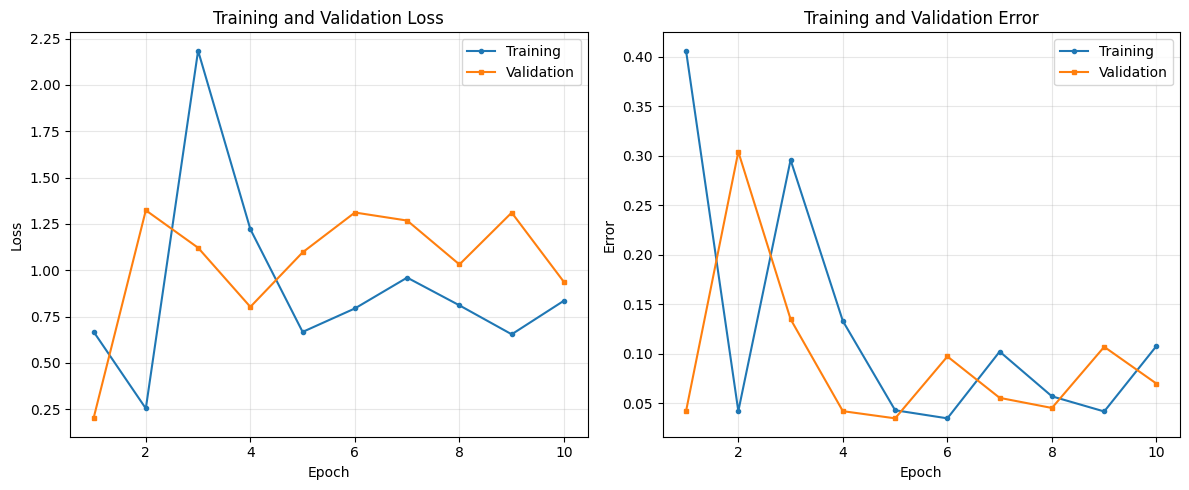

Epoch  11/150 | LR: 0.005 | Train - Loss: 0.600108, Err: 0.074505 | Val - Loss: 0.788151, Err: 0.068794
Epoch  12/150 | LR: 0.005 | Train - Loss: 0.458630, Err: 0.056942 | Val - Loss: 0.612637, Err: 0.054247
Epoch  13/150 | LR: 0.005 | Train - Loss: 0.435357, Err: 0.056898 | Val - Loss: 0.658063, Err: 0.059149
Epoch  14/150 | LR: 0.005 | Train - Loss: 0.450567, Err: 0.066718 | Val - Loss: 0.735383, Err: 0.050044
Epoch  15/150 | LR: 0.005 | Train - Loss: 0.447540, Err: 0.049490 | Val - Loss: 0.723838, Err: 0.054218
Epoch  16/150 | LR: 0.005 | Train - Loss: 0.414678, Err: 0.049097 | Val - Loss: 0.692043, Err: 0.050503
Epoch  17/150 | LR: 0.005 | Train - Loss: 0.391941, Err: 0.046875 | Val - Loss: 0.563857, Err: 0.047975
Epoch  18/150 | LR: 0.005 | Train - Loss: 0.329893, Err: 0.044646 | Val - Loss: 0.445169, Err: 0.059317
Epoch  19/150 | LR: 0.005 | Train - Loss: 0.291239, Err: 0.056665 | Val - Loss: 0.432949, Err: 0.076566
Epoch  20/150 | LR: 0.005 | Train - Loss: 0.288576, Err: 0.07223

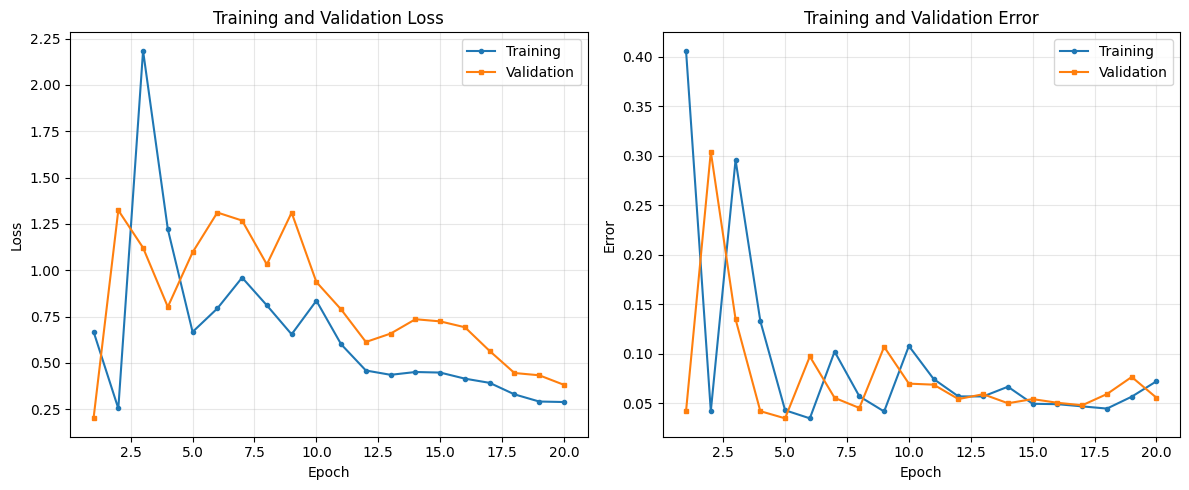

Epoch  21/150 | LR: 0.005 | Train - Loss: 0.253487, Err: 0.052469 | Val - Loss: 0.315305, Err: 0.046984
Epoch  22/150 | LR: 0.005 | Train - Loss: 0.227601, Err: 0.043619 | Val - Loss: 0.264350, Err: 0.042592
Epoch  23/150 | LR: 0.005 | Train - Loss: 0.204380, Err: 0.037391 | Val - Loss: 0.260537, Err: 0.051595
Epoch  24/150 | LR: 0.005 | Train - Loss: 0.197775, Err: 0.042992 | Val - Loss: 0.226266, Err: 0.047276
Epoch  25/150 | LR: 0.005 | Train - Loss: 0.173283, Err: 0.041215 | Val - Loss: 0.215589, Err: 0.044151
Epoch  26/150 | LR: 0.005 | Train - Loss: 0.152232, Err: 0.043444 | Val - Loss: 0.202454, Err: 0.045447
Epoch  27/150 | LR: 0.005 | Train - Loss: 0.135034, Err: 0.040392 | Val - Loss: 0.181038, Err: 0.042286
Epoch  28/150 | LR: 0.005 | Train - Loss: 0.131989, Err: 0.044318 | Val - Loss: 0.171586, Err: 0.038855
Epoch  29/150 | LR: 0.005 | Train - Loss: 0.123030, Err: 0.036772 | Val - Loss: 0.158583, Err: 0.036961
Epoch  30/150 | LR: 0.005 | Train - Loss: 0.119848, Err: 0.03576

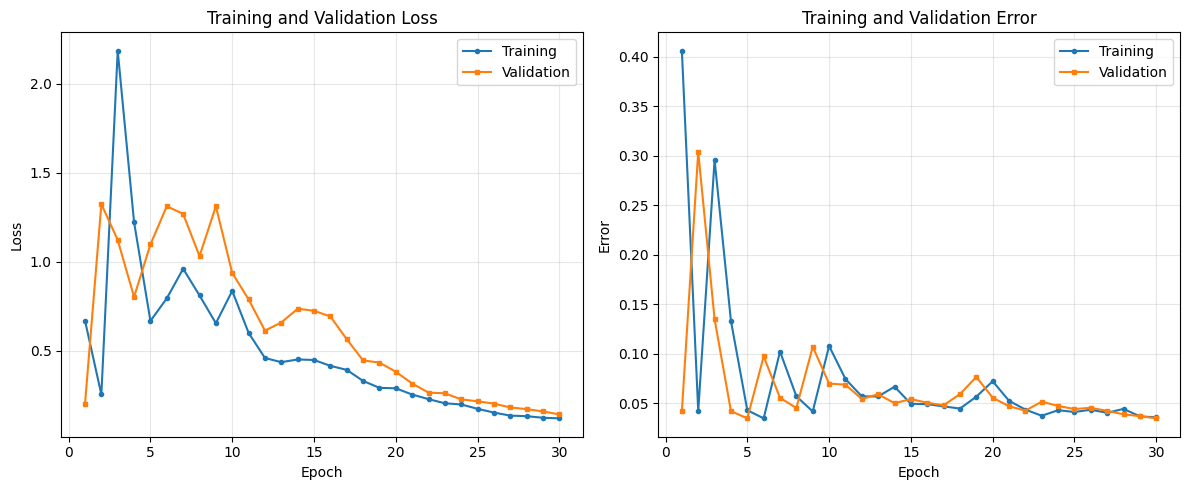

Epoch  31/150 | LR: 0.005 | Train - Loss: 0.112557, Err: 0.032612 | Val - Loss: 0.133509, Err: 0.036269
Epoch  32/150 | LR: 0.005 | Train - Loss: 0.107451, Err: 0.031265 | Val - Loss: 0.130269, Err: 0.040647
Epoch  33/150 | LR: 0.005 | Train - Loss: 0.109200, Err: 0.034623 | Val - Loss: 0.127954, Err: 0.039875
Epoch  34/150 | LR: 0.005 | Train - Loss: 0.109525, Err: 0.032707 | Val - Loss: 0.113207, Err: 0.037711
Epoch  35/150 | LR: 0.005 | Train - Loss: 0.101451, Err: 0.033508 | Val - Loss: 0.104514, Err: 0.034739
Epoch  36/150 | LR: 0.005 | Train - Loss: 0.093208, Err: 0.030769 | Val - Loss: 0.101663, Err: 0.034601
Epoch  37/150 | LR: 0.005 | Train - Loss: 0.091109, Err: 0.030733 | Val - Loss: 0.104830, Err: 0.036538
Epoch  38/150 | LR: 0.005 | Train - Loss: 0.090957, Err: 0.031235 | Val - Loss: 0.104685, Err: 0.038192
Epoch  39/150 | LR: 0.005 | Train - Loss: 0.089159, Err: 0.031571 | Val - Loss: 0.095842, Err: 0.035125
Epoch  40/150 | LR: 0.005 | Train - Loss: 0.084740, Err: 0.02975

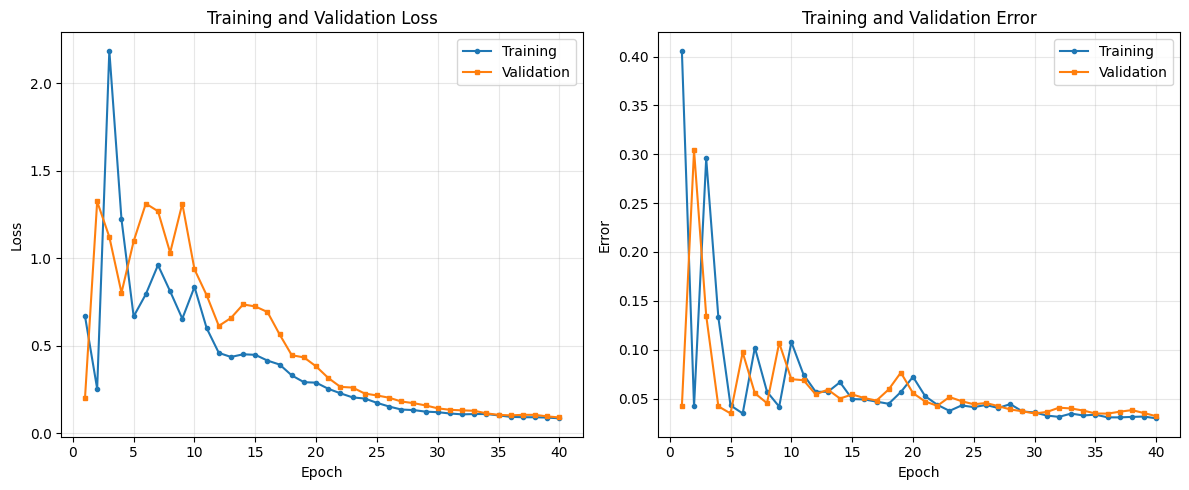

Epoch  41/150 | LR: 0.005 | Train - Loss: 0.082498, Err: 0.029269 | Val - Loss: 0.088010, Err: 0.030813
Epoch  42/150 | LR: 0.005 | Train - Loss: 0.082069, Err: 0.029072 | Val - Loss: 0.085157, Err: 0.030398
Epoch  43/150 | LR: 0.005 | Train - Loss: 0.080330, Err: 0.028169 | Val - Loss: 0.081224, Err: 0.029997
Epoch  44/150 | LR: 0.005 | Train - Loss: 0.077302, Err: 0.028038 | Val - Loss: 0.080048, Err: 0.029822
Epoch  45/150 | LR: 0.005 | Train - Loss: 0.075660, Err: 0.027834 | Val - Loss: 0.078733, Err: 0.028897
Epoch  46/150 | LR: 0.005 | Train - Loss: 0.074297, Err: 0.027309 | Val - Loss: 0.075599, Err: 0.027222
Epoch  47/150 | LR: 0.005 | Train - Loss: 0.072651, Err: 0.026632 | Val - Loss: 0.073330, Err: 0.026399
Epoch  48/150 | LR: 0.005 | Train - Loss: 0.071848, Err: 0.026326 | Val - Loss: 0.072317, Err: 0.026151
Epoch  49/150 | LR: 0.005 | Train - Loss: 0.070924, Err: 0.026362 | Val - Loss: 0.072169, Err: 0.026267
Epoch  50/150 | LR: 0.005 | Train - Loss: 0.070003, Err: 0.02575

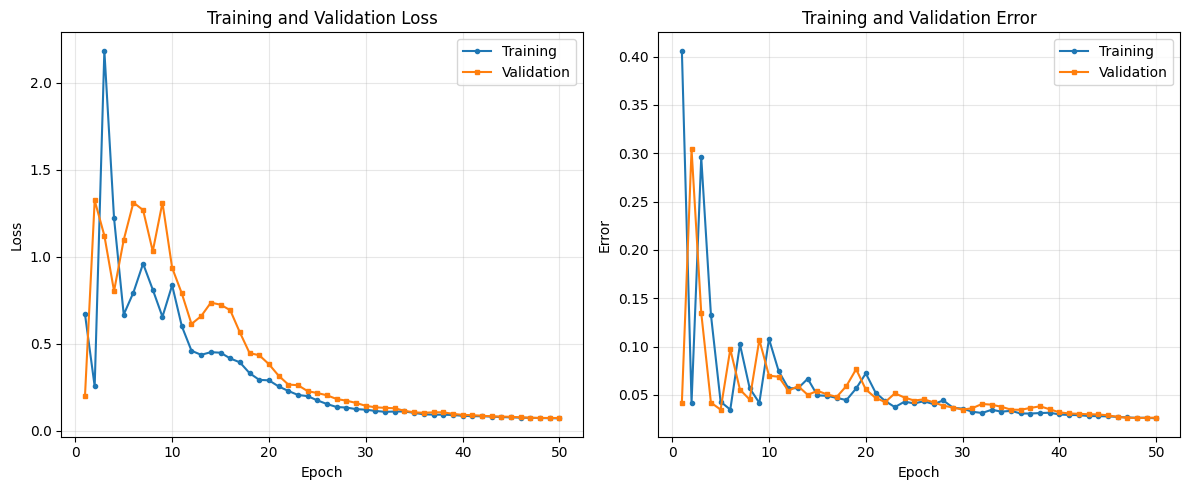

Epoch  51/150 | LR: 0.005 | Train - Loss: 0.069387, Err: 0.025342 | Val - Loss: 0.070679, Err: 0.026304
Epoch  52/150 | LR: 0.005 | Train - Loss: 0.068279, Err: 0.025219 | Val - Loss: 0.068851, Err: 0.025612
Epoch  53/150 | LR: 0.005 | Train - Loss: 0.066820, Err: 0.024767 | Val - Loss: 0.067381, Err: 0.024978
Epoch  54/150 | LR: 0.005 | Train - Loss: 0.065196, Err: 0.024184 | Val - Loss: 0.066445, Err: 0.024381
Epoch  55/150 | LR: 0.005 | Train - Loss: 0.064125, Err: 0.023652 | Val - Loss: 0.065146, Err: 0.023907
Epoch  56/150 | LR: 0.005 | Train - Loss: 0.063115, Err: 0.023055 | Val - Loss: 0.063872, Err: 0.023827
Epoch  57/150 | LR: 0.005 | Train - Loss: 0.062176, Err: 0.023062 | Val - Loss: 0.063095, Err: 0.024002
Epoch  58/150 | LR: 0.005 | Train - Loss: 0.061472, Err: 0.022888 | Val - Loss: 0.062093, Err: 0.023536
Epoch  59/150 | LR: 0.005 | Train - Loss: 0.060404, Err: 0.022713 | Val - Loss: 0.061012, Err: 0.023062
Epoch  60/150 | LR: 0.005 | Train - Loss: 0.059345, Err: 0.02231

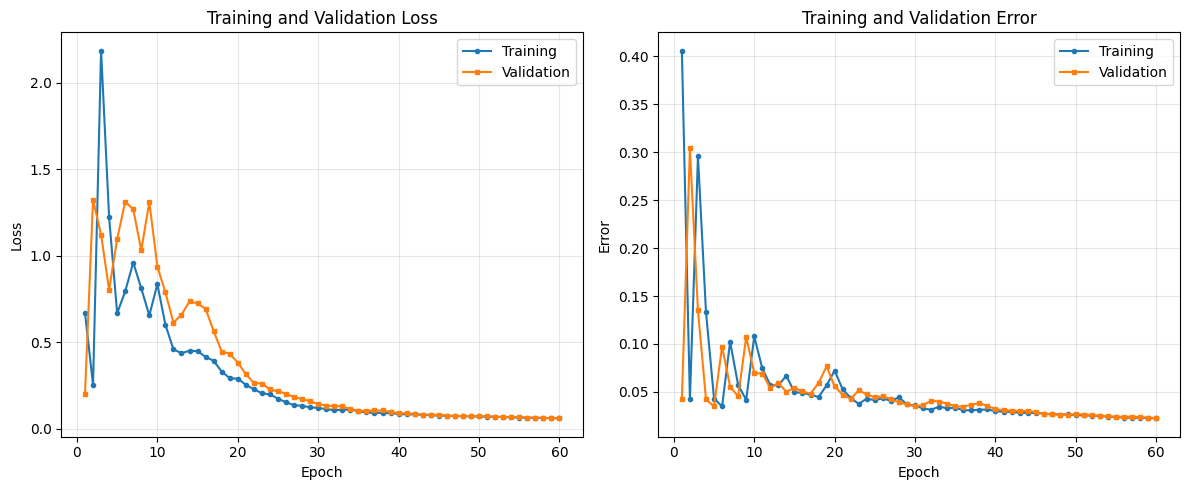

Epoch  61/150 | LR: 0.005 | Train - Loss: 0.058398, Err: 0.021831 | Val - Loss: 0.059279, Err: 0.022203
Epoch  62/150 | LR: 0.005 | Train - Loss: 0.057413, Err: 0.021489 | Val - Loss: 0.058633, Err: 0.021955
Epoch  63/150 | LR: 0.005 | Train - Loss: 0.056423, Err: 0.020899 | Val - Loss: 0.058096, Err: 0.021737
Epoch  64/150 | LR: 0.005 | Train - Loss: 0.055545, Err: 0.020404 | Val - Loss: 0.057201, Err: 0.021525
Epoch  65/150 | LR: 0.005 | Train - Loss: 0.054573, Err: 0.019981 | Val - Loss: 0.056029, Err: 0.021117
Epoch  66/150 | LR: 0.005 | Train - Loss: 0.053503, Err: 0.019777 | Val - Loss: 0.055069, Err: 0.020775
Epoch  67/150 | LR: 0.005 | Train - Loss: 0.052624, Err: 0.019602 | Val - Loss: 0.054257, Err: 0.020469
Epoch  68/150 | LR: 0.005 | Train - Loss: 0.051669, Err: 0.019442 | Val - Loss: 0.053590, Err: 0.020010
Epoch  69/150 | LR: 0.005 | Train - Loss: 0.050653, Err: 0.018859 | Val - Loss: 0.053086, Err: 0.019639
Epoch  70/150 | LR: 0.005 | Train - Loss: 0.049650, Err: 0.01840

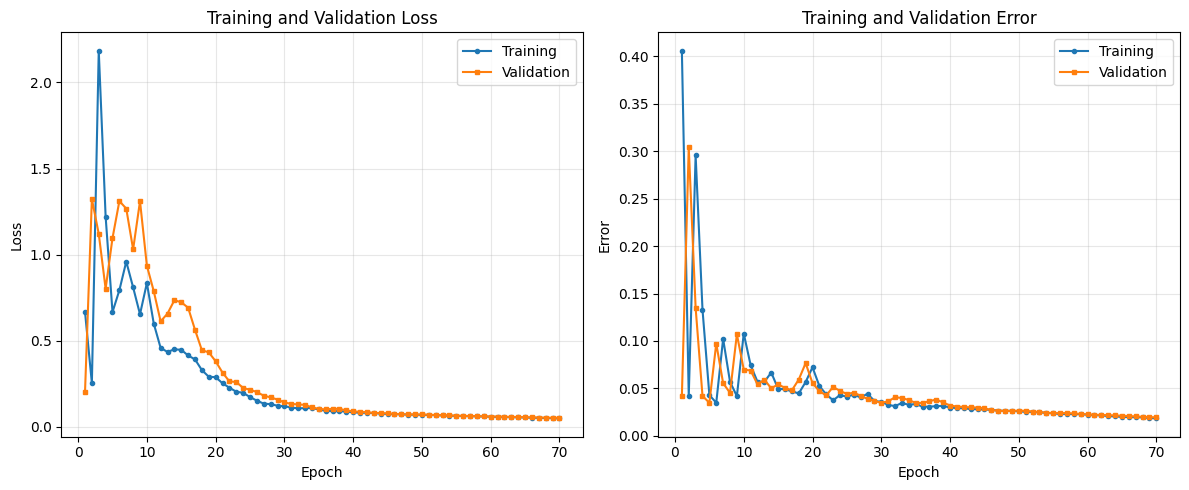

Epoch  71/150 | LR: 0.005 | Train - Loss: 0.048695, Err: 0.018073 | Val - Loss: 0.051905, Err: 0.019216
Epoch  72/150 | LR: 0.005 | Train - Loss: 0.047749, Err: 0.017468 | Val - Loss: 0.051109, Err: 0.018553
Epoch  73/150 | LR: 0.005 | Train - Loss: 0.046770, Err: 0.016900 | Val - Loss: 0.050804, Err: 0.018262
Epoch  74/150 | LR: 0.005 | Train - Loss: 0.045859, Err: 0.016477 | Val - Loss: 0.050760, Err: 0.018277
Epoch  75/150 | LR: 0.005 | Train - Loss: 0.044932, Err: 0.015997 | Val - Loss: 0.050325, Err: 0.018051
Epoch  76/150 | LR: 0.005 | Train - Loss: 0.043930, Err: 0.015538 | Val - Loss: 0.050039, Err: 0.017941
Epoch  77/150 | LR: 0.005 | Train - Loss: 0.042985, Err: 0.015195 | Val - Loss: 0.049919, Err: 0.017810
Epoch  78/150 | LR: 0.005 | Train - Loss: 0.042030, Err: 0.014714 | Val - Loss: 0.049019, Err: 0.017490
Epoch  79/150 | LR: 0.005 | Train - Loss: 0.041067, Err: 0.014226 | Val - Loss: 0.048575, Err: 0.017584
Epoch  80/150 | LR: 0.005 | Train - Loss: 0.040069, Err: 0.01403

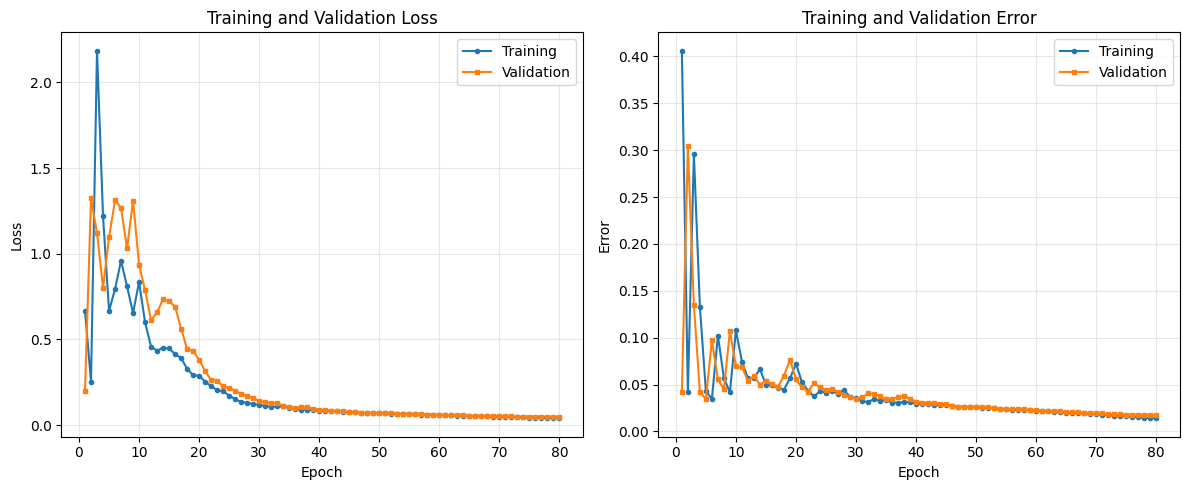

Epoch  81/150 | LR: 0.005 | Train - Loss: 0.039132, Err: 0.013658 | Val - Loss: 0.046982, Err: 0.016929
Epoch  82/150 | LR: 0.005 | Train - Loss: 0.038220, Err: 0.013265 | Val - Loss: 0.046488, Err: 0.016805
Epoch  83/150 | LR: 0.005 | Train - Loss: 0.037301, Err: 0.012995 | Val - Loss: 0.046489, Err: 0.016754
Epoch  84/150 | LR: 0.005 | Train - Loss: 0.036369, Err: 0.012777 | Val - Loss: 0.044374, Err: 0.016047
Epoch  85/150 | LR: 0.005 | Train - Loss: 0.035783, Err: 0.012274 | Val - Loss: 0.049488, Err: 0.017614
Epoch  86/150 | LR: 0.005 | Train - Loss: 0.036614, Err: 0.013440 | Val - Loss: 0.042093, Err: 0.015647
Epoch  87/150 | LR: 0.005 | Train - Loss: 0.039145, Err: 0.014022 | Val - Loss: 0.045203, Err: 0.016761
Epoch  88/150 | LR: 0.005 | Train - Loss: 0.034910, Err: 0.013192 | Val - Loss: 0.048661, Err: 0.017635
Epoch  89/150 | LR: 0.005 | Train - Loss: 0.034537, Err: 0.012413 | Val - Loss: 0.042837, Err: 0.015683
Epoch  90/150 | LR: 0.005 | Train - Loss: 0.033230, Err: 0.01129

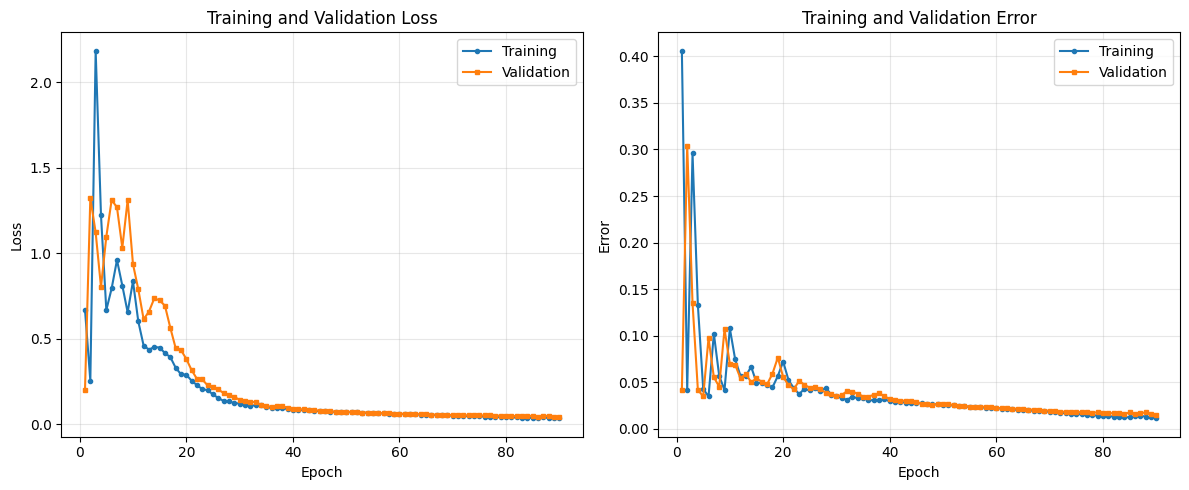

Epoch  91/150 | LR: 0.005 | Train - Loss: 0.032540, Err: 0.011750 | Val - Loss: 0.038484, Err: 0.014846
Epoch  92/150 | LR: 0.005 | Train - Loss: 0.031293, Err: 0.011444 | Val - Loss: 0.042719, Err: 0.015443
Epoch  93/150 | LR: 0.005 | Train - Loss: 0.030197, Err: 0.010876 | Val - Loss: 0.044128, Err: 0.015319
Epoch  94/150 | LR: 0.005 | Train - Loss: 0.029861, Err: 0.010278 | Val - Loss: 0.039389, Err: 0.014663
Epoch  95/150 | LR: 0.005 | Train - Loss: 0.028263, Err: 0.009987 | Val - Loss: 0.038048, Err: 0.014707
Epoch  96/150 | LR: 0.005 | Train - Loss: 0.028085, Err: 0.010103 | Val - Loss: 0.039741, Err: 0.014540
Epoch  97/150 | LR: 0.005 | Train - Loss: 0.026208, Err: 0.008530 | Val - Loss: 0.044924, Err: 0.015589
Epoch  98/150 | LR: 0.005 | Train - Loss: 0.026176, Err: 0.009025 | Val - Loss: 0.040435, Err: 0.014700
Epoch  99/150 | LR: 0.005 | Train - Loss: 0.025106, Err: 0.008894 | Val - Loss: 0.037000, Err: 0.013935
Epoch 100/150 | LR: 0.005 | Train - Loss: 0.024317, Err: 0.00810

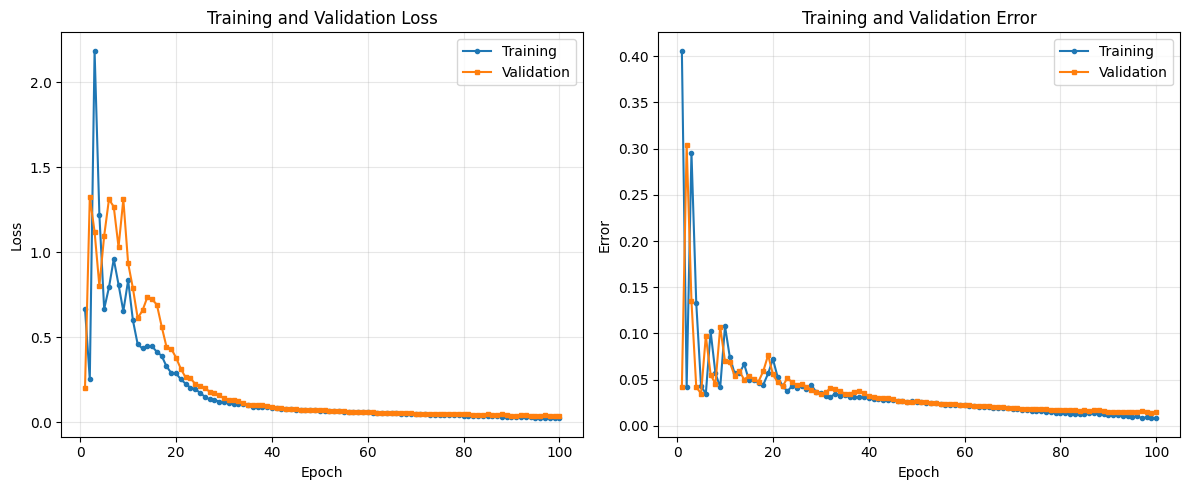

Epoch 101/150 | LR: 0.005 | Train - Loss: 0.023585, Err: 0.007503 | Val - Loss: 0.041850, Err: 0.014846
Epoch 102/150 | LR: 0.005 | Train - Loss: 0.022683, Err: 0.007670 | Val - Loss: 0.037103, Err: 0.013884
Epoch 103/150 | LR: 0.005 | Train - Loss: 0.022148, Err: 0.007568 | Val - Loss: 0.035436, Err: 0.013505
Epoch 104/150 | LR: 0.005 | Train - Loss: 0.021250, Err: 0.007000 | Val - Loss: 0.035785, Err: 0.013381
Epoch 105/150 | LR: 0.005 | Train - Loss: 0.020600, Err: 0.006330 | Val - Loss: 0.036992, Err: 0.013199
Epoch 106/150 | LR: 0.005 | Train - Loss: 0.019824, Err: 0.006316 | Val - Loss: 0.037238, Err: 0.013112
Epoch 107/150 | LR: 0.005 | Train - Loss: 0.019325, Err: 0.006330 | Val - Loss: 0.034372, Err: 0.012602
Epoch 108/150 | LR: 0.005 | Train - Loss: 0.018619, Err: 0.005653 | Val - Loss: 0.040088, Err: 0.014481
Epoch 109/150 | LR: 0.005 | Train - Loss: 0.017946, Err: 0.005653 | Val - Loss: 0.039949, Err: 0.013899
Epoch 110/150 | LR: 0.005 | Train - Loss: 0.017386, Err: 0.00554

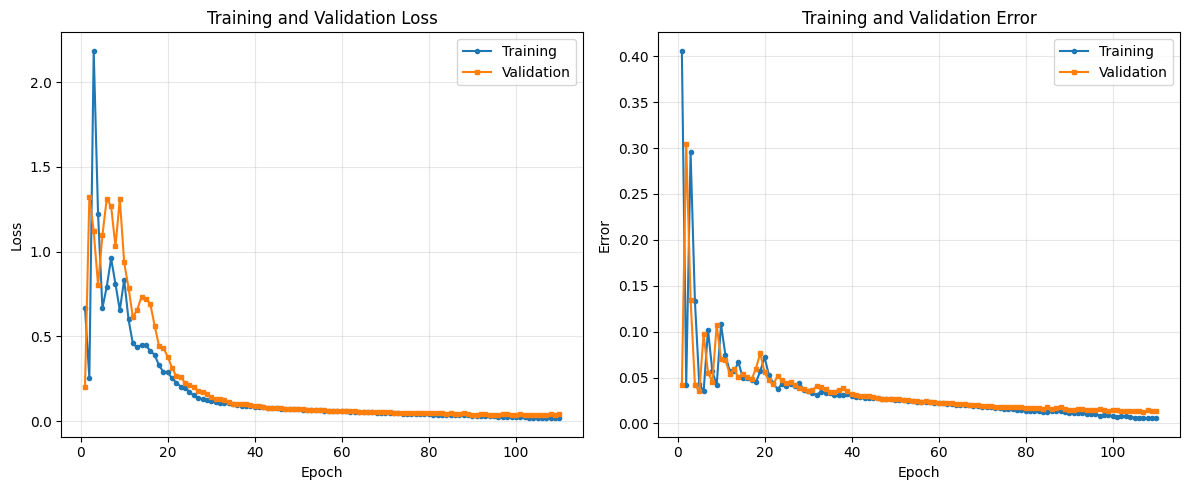

Epoch 111/150 | LR: 0.005 | Train - Loss: 0.016694, Err: 0.005259 | Val - Loss: 0.031126, Err: 0.011852
Epoch 112/150 | LR: 0.005 | Train - Loss: 0.016360, Err: 0.004793 | Val - Loss: 0.030356, Err: 0.011466
Epoch 113/150 | LR: 0.005 | Train - Loss: 0.015626, Err: 0.004939 | Val - Loss: 0.026796, Err: 0.009885
Epoch 114/150 | LR: 0.005 | Train - Loss: 0.015188, Err: 0.004655 | Val - Loss: 0.027816, Err: 0.010599
Epoch 115/150 | LR: 0.005 | Train - Loss: 0.014711, Err: 0.004371 | Val - Loss: 0.023689, Err: 0.008814
Epoch 116/150 | LR: 0.005 | Train - Loss: 0.014443, Err: 0.004116 | Val - Loss: 0.026967, Err: 0.010490
Epoch 117/150 | LR: 0.005 | Train - Loss: 0.014253, Err: 0.004684 | Val - Loss: 0.021375, Err: 0.007904
Epoch 118/150 | LR: 0.005 | Train - Loss: 0.014340, Err: 0.004305 | Val - Loss: 0.032959, Err: 0.012456
Epoch 119/150 | LR: 0.005 | Train - Loss: 0.014820, Err: 0.005332 | Val - Loss: 0.017763, Err: 0.006104
Epoch 120/150 | LR: 0.005 | Train - Loss: 0.014843, Err: 0.00481

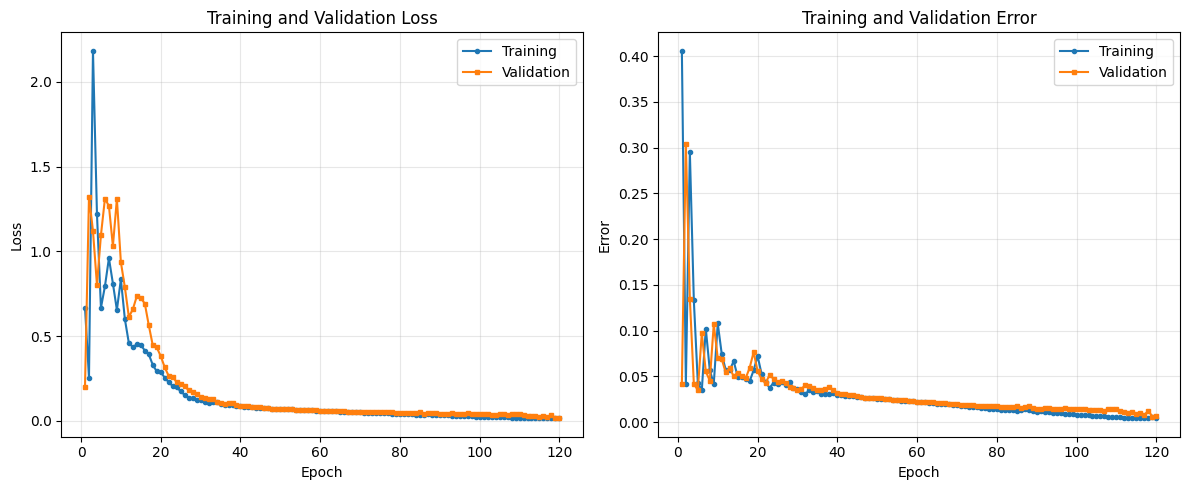

Epoch 121/150 | LR: 0.005 | Train - Loss: 0.012814, Err: 0.004210 | Val - Loss: 0.018001, Err: 0.006148
Epoch 122/150 | LR: 0.005 | Train - Loss: 0.012731, Err: 0.004108 | Val - Loss: 0.016162, Err: 0.005063
Epoch 123/150 | LR: 0.005 | Train - Loss: 0.012630, Err: 0.003322 | Val - Loss: 0.016168, Err: 0.005631
Epoch 124/150 | LR: 0.005 | Train - Loss: 0.011289, Err: 0.003132 | Val - Loss: 0.017338, Err: 0.006753
Epoch 125/150 | LR: 0.005 | Train - Loss: 0.011578, Err: 0.003824 | Val - Loss: 0.014665, Err: 0.004830
Epoch 126/150 | LR: 0.005 | Train - Loss: 0.010832, Err: 0.002906 | Val - Loss: 0.013971, Err: 0.004356
Epoch 127/150 | LR: 0.005 | Train - Loss: 0.010347, Err: 0.002579 | Val - Loss: 0.015684, Err: 0.005616
Epoch 128/150 | LR: 0.005 | Train - Loss: 0.010309, Err: 0.003220 | Val - Loss: 0.011867, Err: 0.003482
Epoch 129/150 | LR: 0.005 | Train - Loss: 0.009887, Err: 0.002622 | Val - Loss: 0.012727, Err: 0.003970
Epoch 130/150 | LR: 0.005 | Train - Loss: 0.010522, Err: 0.00306

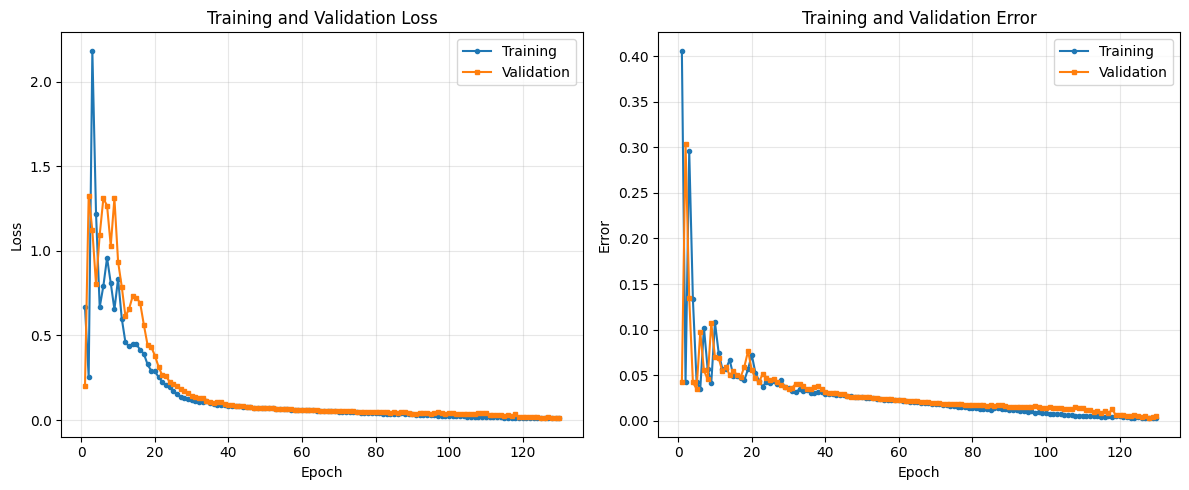

Epoch 131/150 | LR: 0.005 | Train - Loss: 0.011560, Err: 0.003817 | Val - Loss: 0.012451, Err: 0.004087
Epoch 132/150 | LR: 0.005 | Train - Loss: 0.009940, Err: 0.002965 | Val - Loss: 0.011056, Err: 0.003256
Epoch 133/150 | LR: 0.005 | Train - Loss: 0.009029, Err: 0.002295 | Val - Loss: 0.010245, Err: 0.002797
Epoch 134/150 | LR: 0.005 | Train - Loss: 0.009225, Err: 0.002491 | Val - Loss: 0.010058, Err: 0.003059
Epoch 135/150 | LR: 0.005 | Train - Loss: 0.008632, Err: 0.002316 | Val - Loss: 0.010005, Err: 0.002936
Epoch 136/150 | LR: 0.005 | Train - Loss: 0.008140, Err: 0.001945 | Val - Loss: 0.009786, Err: 0.002885
Epoch 137/150 | LR: 0.005 | Train - Loss: 0.008198, Err: 0.002032 | Val - Loss: 0.009334, Err: 0.002652
Epoch 138/150 | LR: 0.005 | Train - Loss: 0.007607, Err: 0.001916 | Val - Loss: 0.009426, Err: 0.002870
Epoch 139/150 | LR: 0.005 | Train - Loss: 0.007467, Err: 0.001916 | Val - Loss: 0.009070, Err: 0.002491
Epoch 140/150 | LR: 0.005 | Train - Loss: 0.007064, Err: 0.00151

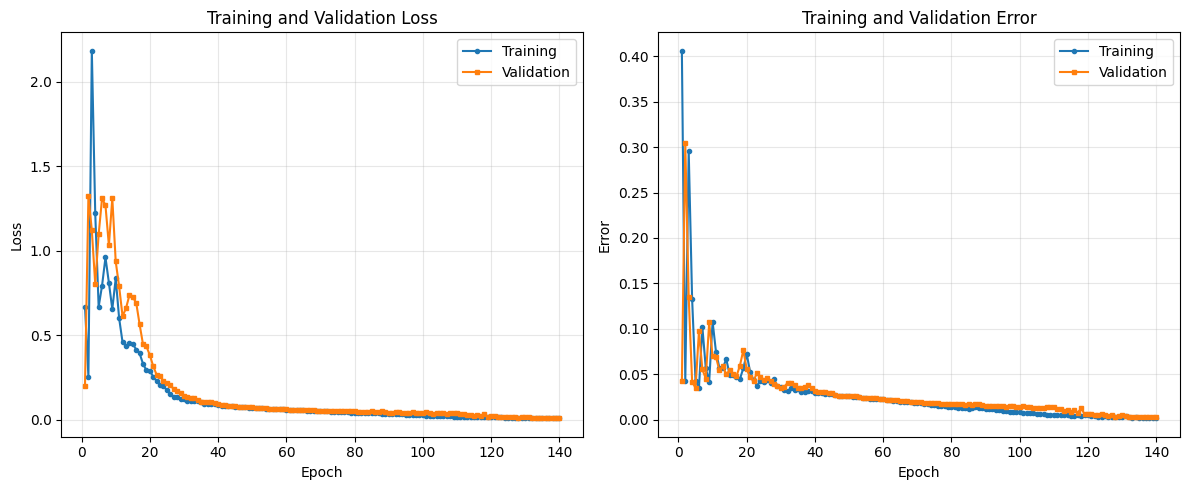

Epoch 141/150 | LR: 0.005 | Train - Loss: 0.007009, Err: 0.001705 | Val - Loss: 0.011181, Err: 0.003569
Epoch 142/150 | LR: 0.005 | Train - Loss: 0.006660, Err: 0.001413 | Val - Loss: 0.008578, Err: 0.002265
Epoch 143/150 | LR: 0.005 | Train - Loss: 0.006363, Err: 0.001318 | Val - Loss: 0.008233, Err: 0.002265
Epoch 144/150 | LR: 0.005 | Train - Loss: 0.006117, Err: 0.001275 | Val - Loss: 0.008872, Err: 0.002673
Epoch 145/150 | LR: 0.005 | Train - Loss: 0.005948, Err: 0.001326 | Val - Loss: 0.007640, Err: 0.001923
Epoch 146/150 | LR: 0.005 | Train - Loss: 0.005835, Err: 0.001107 | Val - Loss: 0.009169, Err: 0.002950
Epoch 147/150 | LR: 0.005 | Train - Loss: 0.005578, Err: 0.001115 | Val - Loss: 0.007660, Err: 0.002316
Epoch 148/150 | LR: 0.005 | Train - Loss: 0.005543, Err: 0.001071 | Val - Loss: 0.008265, Err: 0.002688
Epoch 149/150 | LR: 0.005 | Train - Loss: 0.005192, Err: 0.000925 | Val - Loss: 0.007424, Err: 0.002163
Achieved near-perfect training error (0.000925) at epoch 149
Mod

In [10]:
from torch.utils.data import Subset

# Reproducibility & deterministic ops
torch.manual_seed(42)
np.random.seed(42)
try:
    torch.use_deterministic_algorithms(True)
except Exception:
    pass
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Build the training dataset
train_dataset = PianoTranscriptionDataset(
    dataset_splits['train'],
    split_name='train',
    musdb_stems=musdb_stems,
    cache_dir=cache_dir
)

overfit_size = 15

def create_memory_efficient_overfit_loader(dataset, num_examples=4, batch_size=2):
    """
    Alternative setup for when you want slightly larger datasets but smaller batches
    """
    overfit_size = min(num_examples, len(dataset))
    overfit_indices = list(range(overfit_size))
    overfit_subset = Subset(dataset, overfit_indices)

    loader = DataLoader(
        overfit_subset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        drop_last=False,
        collate_fn=collate_batch
    )

    print(f"Memory-efficient setup: {overfit_size} examples, batch size {batch_size}")
    return loader

# Example usage of memory-efficient version:
overfit_loader = create_memory_efficient_overfit_loader(train_dataset, num_examples=5, batch_size=5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
overfit_model_b = CRNN_OnsetsAndFrames().to(device)

train_losses_agg, train_errors_agg, val_losses_agg, val_errors_agg, lrs_agg = train(
        model=overfit_model_b,
        train_loader=overfit_loader,
        val_loader=overfit_loader,
        num_epochs=150,
        save_path="overfitted",
        lr=5e-3,
        lr_policy="none",
        weight_decay=0.0,
        grad_clip=1.0,  # Prevent exploding gradients
    )

print(f"Aggressive training final error: {train_errors_agg[-1]:.6f}")

In [17]:
from torch.utils.data import Subset

# Reproducibility & deterministic ops
torch.manual_seed(42)
np.random.seed(42)
try:
    torch.use_deterministic_algorithms(True)
except Exception:
    pass
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


def create_memory_efficient_overfit_loader(dataset, num_examples, batch_size):
    """
    Alternative setup for when you want slightly larger datasets but smaller batches
    """
    overfit_size = min(num_examples, len(dataset))
    overfit_indices = list(range(overfit_size))
    overfit_subset = Subset(dataset, overfit_indices)

    loader = DataLoader(
        overfit_subset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        drop_last=False,
        collate_fn=collate_batch
    )

    print(f"Memory-efficient setup: {overfit_size} examples, batch size {batch_size}")
    return loader

# Example usage of memory-efficient version:
overfit_loader = create_memory_efficient_overfit_loader(train_dataset, num_examples=15, batch_size=15)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
overfit_model_a = CRNN_OnsetsAndFrames().to(device)

train_losses_agg, train_errors_agg, val_losses_agg, val_errors_agg, lrs_agg = train(
        model=overfit_model_a,
        train_loader=overfit_loader,
        val_loader=overfit_loader,
        num_epochs=150,
        save_path="overfitted",
        lr=5e-3,
        lr_policy="none",
        weight_decay=0.0,
        grad_clip=1.0,  # Prevent exploding gradients
    )

print(f"Aggressive training final error: {train_errors_agg[-1]:.6f}")

Memory-efficient setup: 15 examples, batch size 15
Training configuration:
  Device: cpu
  Epochs: 150
  Initial LR: 0.005
  LR Policy: none
  Weight Decay: 0.0
  Gradient Clipping: 1.0
  Model Save Directory: /content/drive/MyDrive/APS360_Team_2_Project/models


KeyboardInterrupt: 

In [13]:
import torch
import json

def save_model_for_website(model, model_name="piano_transcription_trained.pth"):
    """Save trained model for website"""
    try:
        # Save model weights
        torch.save(model.state_dict(), model_name)
        print(f"✅ Model saved: {model_name}")

        # Model info
        total_params = sum(p.numel() for p in model.parameters())
        print(f"📊 Parameters: {total_params:,}")
        print(f"📊 Size: {total_params * 4 / (1024*1024):.1f} MB")

        return True
    except Exception as e:
        print(f"❌ Error: {e}")
        return False

# Save your trained model (replace with your actual model variable)
success = save_model_for_website(overfit_model_a, "piano_transcription_epoch52.pth")

if success:
    print("🎉 Model saved! Download it from Colab Files tab")


NameError: name 'overfit_model_a' is not defined

In [26]:
# Access the original file path from metadata
sample_0_data = train_dataset[0]
metadata = sample_0_data['metadata']
print("Metadata content:", metadata)

# Try to get original file paths
if hasattr(metadata, 'item'):
    metadata_dict = metadata.item()  # Convert numpy object to dict
else:
    metadata_dict = metadata

print(
    "Metadata keys:",
    metadata_dict.keys() if hasattr(metadata_dict, 'keys') else "Not a dict"
)

# Look for audio and MIDI file paths
if 'audio_filename' in metadata_dict:
    audio_path = metadata_dict['audio_filename']
    print(f"Original audio: {audio_path}")

if 'midi_filename' in metadata_dict:
    midi_path = metadata_dict['midi_filename']
    print(f"Original MIDI: {midi_path}")


Metadata content: {'audio_path': PosixPath('/content/drive/MyDrive/APS360_Piano_Transcription/data/raw/maestro-v3.0.0/2009/MIDI-Unprocessed_18_R1_2009_01-03_ORIG_MID--AUDIO_18_R1_2009_18_R1_2009_02_WAV.wav'), 'midi_path': PosixPath('/content/drive/MyDrive/APS360_Piano_Transcription/data/raw/maestro-v3.0.0/2009/MIDI-Unprocessed_18_R1_2009_01-03_ORIG_MID--AUDIO_18_R1_2009_18_R1_2009_02_WAV.midi'), 'duration': 668.431489688, 'title': 'Sonata Bb, Op. 24, No. 2', 'composer': 'Muzio Clementi', 'year': 2009, 'split': 'train', 'dataset': 'maestro'}
Metadata keys: dict_keys(['audio_path', 'midi_path', 'duration', 'title', 'composer', 'year', 'split', 'dataset'])
